In [1]:
!pip install ta
!pip install yfinance



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
# --- Configuration ---
TARGET_TICKER = 'TSLA'
BENCHMARK_TICKER = 'SPY'
START_DATE = '2010-01-01'
VOLATILITY_THRESHOLD_PERCENTILE = 0.70  # Top 15% of days are 'high volatility'
TRAIN_SPLIT_RATIO = 0.70
VALIDATION_SPLIT_RATIO = 0.15
# Test split will be (1 - TRAIN_SPLIT_RATIO - VALIDATION_SPLIT_RATIO)

In [4]:
def download_data(ticker, start_date):
    """Downloads historical stock data for a single ticker."""
    print(f"Downloading data for {ticker}...")
    data = yf.download(ticker, start=start_date, auto_adjust=True)
    # Ensure index is DatetimeIndex
    data.index = pd.to_datetime(data.index)
    return data

In [5]:
def engineer_features(data, ticker_prefix):
    """Engineers volatility, RSI, and SMA features for a given dataframe."""

    # 1. Volatility
    # (High - Low) / Close
    data[f'Volatility_{ticker_prefix}'] = (data['High'] - data['Low']) / data['Close']

    # 2. RSI (Relative Strength Index) - 14 day window
    data[f'RSI_{ticker_prefix}'] = ta.momentum.RSIIndicator(data['Close'].squeeze(), window=14).rsi()

    # 3. SMA (Simple Moving Average) - 21 day window
    data[f'SMA_21_{ticker_prefix}'] = ta.trend.SMAIndicator(data['Close'].squeeze(), window=21).sma_indicator()

    # 4. Daily Return
    # (Close - Open) / Open
    data[f'Return_{ticker_prefix}'] = (data['Close'] - data['Open']) / data['Open']

    # Select only the features we care about, prefixing them
    feature_cols = [
        f'Volatility_{ticker_prefix}',
        f'RSI_{ticker_prefix}',
        f'SMA_21_{ticker_prefix}',
        f'Return_{ticker_prefix}',
        f'Volume_{ticker_prefix}' # Use Volume as a feature
    ]
    # Rename Volume to be prefixed
    data = data.rename(columns={'Volume': f'Volume_{ticker_prefix}'})

    return data[feature_cols]

In [6]:
def create_target_variable(df, target_col, threshold_percentile):
    """Creates a binary target variable based on a percentile threshold."""

    # 1. Define the volatility threshold
    volatility_threshold = df[target_col].quantile(threshold_percentile)
    print(f"Volatility threshold ({threshold_percentile*100}th percentile): {volatility_threshold:.4f}")

    # 2. Create the binary target
    # 1 if volatility is *above* the threshold, 0 otherwise
    df['Target'] = (df[target_col] > volatility_threshold).astype(int)

    # 3. CRITICAL: Shift the target
    # We are predicting *tomorrow's* volatility using *today's* features.
    # So, shift the 'Target' column back by one day.
    df['Target'] = df['Target'].shift(-1)

    return df

In [7]:
def scale_data(train_df, val_df, test_df, feature_cols):
    """Fits a MinMaxScaler on the training data and transforms all splits."""

    scaler = MinMaxScaler()

    # Fit *only* on the training data to prevent data leakage
    scaler.fit(train_df[feature_cols])

    # Transform all datasets
    train_df[feature_cols] = scaler.transform(train_df[feature_cols])
    val_df[feature_cols] = scaler.transform(val_df[feature_cols])
    test_df[feature_cols] = scaler.transform(test_df[feature_cols])

    print("Data scaling complete.")

    return train_df, val_df, test_df, scaler

In [8]:
def load_and_preprocess_data():
    """Main function to run the entire data preparation pipeline."""

    # 1. Download Data
    tsla_data = download_data(TARGET_TICKER, START_DATE)
    spy_data = download_data(BENCHMARK_TICKER, START_DATE)

    # 2. Engineer Features for each ticker
    tsla_features = engineer_features(tsla_data.copy(), TARGET_TICKER)
    spy_features = engineer_features(spy_data.copy(), BENCHMARK_TICKER)

    # 3. Merge features into one DataFrame
    # Use an inner join to align all trading days
    df = pd.merge(tsla_features, spy_features, on='Date', how='inner')

    # Flatten multi-level columns if they exist, converting them to simple strings
    # E.g., ('FeatureName', '') -> 'FeatureName'
    # E.g., ('Volume_TSLA', 'TSLA') -> 'Volume_TSLA_TSLA'
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(filter(None, col)) if isinstance(col, tuple) else col for col in df.columns]

    # 4. Create Target Variable (based on TSLA's volatility)
    # Ensure the volatility column name is a string, not a tuple, before passing to create_target_variable
    df = create_target_variable(df, f'Volatility_{TARGET_TICKER}', VOLATILITY_THRESHOLD_PERCENTILE)

    # 5. Clean Data
    # Drop all rows with NaN values. This handles:
    # - NaNs from SMA/RSI calculations (first ~21 days)
    # - The last row, which has a NaN 'Target' due to the shift(-1)
    print(f"Original shape before cleaning: {df.shape}")
    df = df.dropna()
    print(f"Shape after dropping NaNs: {df.shape}")

    # 6. Chronological Split (CRITICAL for time series)
    # Do not shuffle!
    n = len(df)
    train_end = int(n * TRAIN_SPLIT_RATIO)
    val_end = int(n * (TRAIN_SPLIT_RATIO + VALIDATION_SPLIT_RATIO))

    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:val_end]
    test_df = df.iloc[val_end:]

    print(f"Train set shape:  {train_df.shape}")
    print(f"Valid set shape: {val_df.shape}")
    print(f"Test set shape:   {test_df.shape}")

    # 7. Scale Data
    # Identify all feature columns (everything except 'Target')
    # Now df.columns are guaranteed to be simple strings.
    feature_cols = [col for col in df.columns if col != 'Target']

    train_df, val_df, test_df, scaler = scale_data(
        train_df.copy(), val_df.copy(), test_df.copy(), feature_cols
    )

    return train_df, val_df, test_df, scaler, feature_cols

In [9]:
if __name__ == "__main__":
    # Run the full pipeline
    train_df, val_df, test_df, scaler, features = load_and_preprocess_data()

    print("\n--- Preprocessing Complete ---")

    print("\nFeature columns:")
    print(features)

    print(f"\nTraining Set Head:\n{train_df.head()}")

    print(f"\nTraining Target Distribution (Imbalanced):")
    print(train_df['Target'].value_counts(normalize=True))

    print(f"\nScaler object created and fitted. Ready for model training.")


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

Volatility threshold (70.0th percentile): 0.0473
Original shape before cleaning: (3875, 11)
Shape after dropping NaNs: (3854, 11)
Train set shape:  (2697, 11)
Valid set shape: (578, 11)
Test set shape:   (579, 11)
Data scaling complete.

--- Preprocessing Complete ---

Feature columns:
['Volatility_TSLA', 'RSI_TSLA', 'SMA_21_TSLA', 'Return_TSLA', 'Volume_TSLA_TSLA', 'Volatility_SPY', 'RSI_SPY', 'SMA_21_SPY', 'Return_SPY', 'Volume_SPY_SPY']

Training Set Head:
            Volatility_TSLA  RSI_TSLA  SMA_21_TSLA  Return_TSLA  \
Date                                                              
2010-07-28         0.039224  0.405722     0.000130     0.518562   
2010-07-29         0.137681  0.375727     0.000090     0.446768   
2010-07-30         0.143289  0.343335     0.000046     0.465286   
2010-08-02         0.086679  0.431494     0.000034     0.549340   
2010-08-03         0.170890  0.509207     0.000065     0.611702   

            Volume_TSLA_TSLA  Volatility_SPY   RSI_SPY  SMA_21_SPY

In [10]:
# === TensorFlow Training Setup ===
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime, os

# Ensure reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Create logs folder for TensorBoard
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(log_dir, exist_ok=True)

c:\Users\Kat\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.30.2 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\Kat\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.30.2 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\Kat\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.30.2 at tensorflow/core/framework/res

In [11]:
def make_sequences(X, y, seq_length=10):
    """Converts feature and target arrays into rolling sequences for RNN/CNN models."""
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:(i + seq_length)])
        ys.append(y[i + seq_length])
    return np.array(Xs), np.array(ys)

In [12]:
 # === Build Models ===
def build_ffn(input_dim):
    """Feedforward Neural Network for tabular data."""
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def build_lstm(input_shape):
    """Improved LSTM model for sequential data (time series)."""
    model = models.Sequential([
        layers.LSTM(64, input_shape=input_shape, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
        layers.LSTM(32),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def build_cnn(input_shape):
    """Improved 1D CNN for sequential data."""
    model = models.Sequential([
        layers.Conv1D(64, kernel_size=5, activation='relu', input_shape=input_shape),
        layers.Conv1D(32, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [13]:
 # ===  Model Training Pipeline ===
def model_training_pipeline(model_type="ffn", seq_length=10, epochs=30, batch_size=32):
    """
    Trains a TensorFlow model end-to-end with preprocessing integration.
    model_type: 'ffn', 'lstm', or 'cnn'
    """

    print(f"\n=== Starting pipeline for model: {model_type.upper()} ===")

    # Extract actual feature column names from the global 'features' variable and filter out 'Target'
    feature_column_names = [f for f in features if f != 'Target']
    print(f"Features used for model: {feature_column_names}")

    # --- Prepare features and target ---
    X_train, y_train = train_df[feature_column_names].values, train_df['Target'].values
    X_val, y_val = val_df[feature_column_names].values, val_df['Target'].values
    X_test, y_test = test_df[feature_column_names].values, test_df['Target'].values

    # --- Convert to sequences if needed ---
    if model_type in ['lstm', 'cnn']:
        X_train, y_train = make_sequences(X_train, y_train, seq_length)
        X_val, y_val = make_sequences(X_val, y_val, seq_length)
        X_test, y_test = make_sequences(X_test, y_test, seq_length)
        input_shape = (seq_length, X_train.shape[2])
    else:
        input_shape = X_train.shape[1]

    # --- Build model ---
    if model_type == 'ffn':
        model = build_ffn(input_shape)
    elif model_type == 'lstm':
        model = build_lstm(input_shape)
    elif model_type == 'cnn':
        model = build_cnn(input_shape)
    else:
        raise ValueError("model_type must be 'ffn', 'lstm', or 'cnn'.")

    # --- Compile ---
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    # --- TensorBoard callback ---
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=f"{log_dir}/{model_type}", histogram_freq=1)
    early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

    # --- Train ---
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[tb_callback, early_stop],
        verbose=1
    )

    # --- Evaluate ---
    test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}")

    # --- Classification Report ---
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_type.upper()} Confusion Matrix')
    plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.show()

    return model, history


=== Starting pipeline for model: FFN ===
Features used for model: ['Volatility_TSLA', 'RSI_TSLA', 'SMA_21_TSLA', 'Return_TSLA', 'Volume_TSLA_TSLA', 'Volatility_SPY', 'RSI_SPY', 'SMA_21_SPY', 'Return_SPY', 'Volume_SPY_SPY']


c:\Users\Kat\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7241 - auc: 0.5769 - loss: 0.5788 - val_accuracy: 0.6574 - val_auc: 0.6802 - val_loss: 0.6351
Epoch 2/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7634 - auc: 0.7110 - loss: 0.5178 - val_accuracy: 0.6471 - val_auc: 0.7033 - val_loss: 0.6430
Epoch 3/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7679 - auc: 0.7241 - loss: 0.5067 - val_accuracy: 0.6540 - val_auc: 0.7133 - val_loss: 0.6279
Epoch 4/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7653 - auc: 0.7415 - loss: 0.4996 - val_accuracy: 0.6626 - val_auc: 0.7170 - val_loss: 0.6181
Epoch 5/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7683 - auc: 0.7407 - loss: 0.4986 - val_accuracy: 0.6505 - val_auc: 0.7185 - val_loss: 0.6350
Epoch 6/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7746 - auc: 0.7477 - loss: 0.4923 - val_accuracy: 0.6574 - val_auc: 0.7207 - val_loss: 0.6240
Epoch 7/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step -

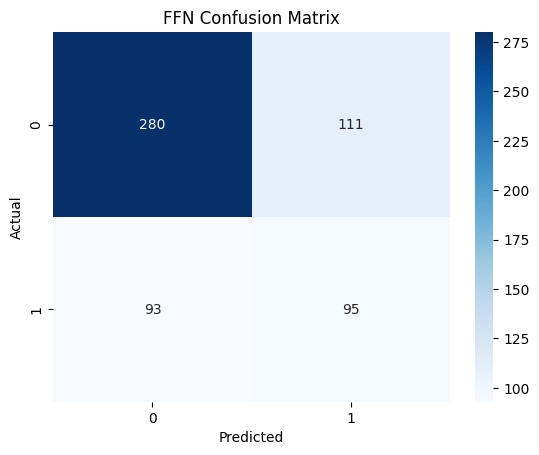


=== Starting pipeline for model: LSTM ===
Features used for model: ['Volatility_TSLA', 'RSI_TSLA', 'SMA_21_TSLA', 'Return_TSLA', 'Volume_TSLA_TSLA', 'Volatility_SPY', 'RSI_SPY', 'SMA_21_SPY', 'Return_SPY', 'Volume_SPY_SPY']
Epoch 1/30


c:\Users\Kat\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.7198 - auc: 0.5052 - loss: 0.5952 - val_accuracy: 0.5792 - val_auc: 0.6913 - val_loss: 0.7339
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7369 - auc: 0.5763 - loss: 0.5687 - val_accuracy: 0.4208 - val_auc: 0.7021 - val_loss: 0.7351
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7391 - auc: 0.6170 - loss: 0.5583 - val_accuracy: 0.4577 - val_auc: 0.7125 - val_loss: 0.7293
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7428 - auc: 0.6275 - loss: 0.5538 - val_accuracy: 0.4208 - val_auc: 0.7129 - val_loss: 0.7169
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7425 - auc: 0.6429 - loss: 0.5501 - val_accuracy: 0.5722 - val_auc: 0.7206 - val_loss: 0.6807
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7421 - auc: 0.6495 - loss: 0.5481 - val_accuracy: 0.6109 - val_auc: 0.7250 - val_loss: 0.6618
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accu

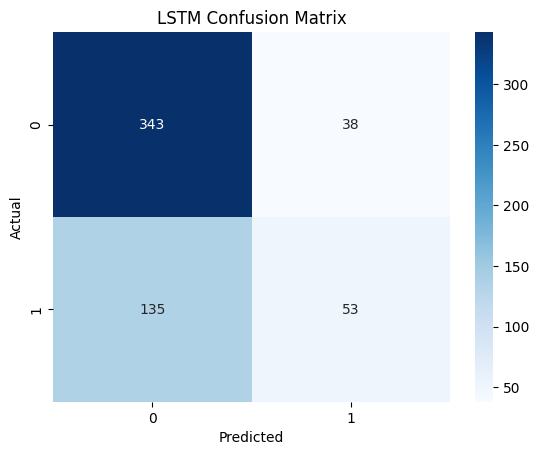


=== Starting pipeline for model: CNN ===
Features used for model: ['Volatility_TSLA', 'RSI_TSLA', 'SMA_21_TSLA', 'Return_TSLA', 'Volume_TSLA_TSLA', 'Volatility_SPY', 'RSI_SPY', 'SMA_21_SPY', 'Return_SPY', 'Volume_SPY_SPY']
Epoch 1/30


c:\Users\Kat\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7358 - auc: 0.5731 - loss: 0.5710 - val_accuracy: 0.6585 - val_auc: 0.6945 - val_loss: 0.6635
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7410 - auc: 0.6733 - loss: 0.5409 - val_accuracy: 0.5792 - val_auc: 0.7147 - val_loss: 0.6783
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7410 - auc: 0.6911 - loss: 0.5329 - val_accuracy: 0.6021 - val_auc: 0.7240 - val_loss: 0.6728
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7462 - auc: 0.6991 - loss: 0.5284 - val_accuracy: 0.5739 - val_auc: 0.7277 - val_loss: 0.6779
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7492 - auc: 0.7038 - loss: 0.5257 - val_accuracy: 0.5493 - val_auc: 0.7320 - val_loss: 0.6840
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7518 - auc: 0.7090 - loss: 0.5226 - val_accuracy: 0.5475 - val_auc: 0.7348 - val_loss: 0.6818

Test Accuracy: 0.6450, Test AUC: 0.6102
18/18 ━━━━━━━━━━━━━━━

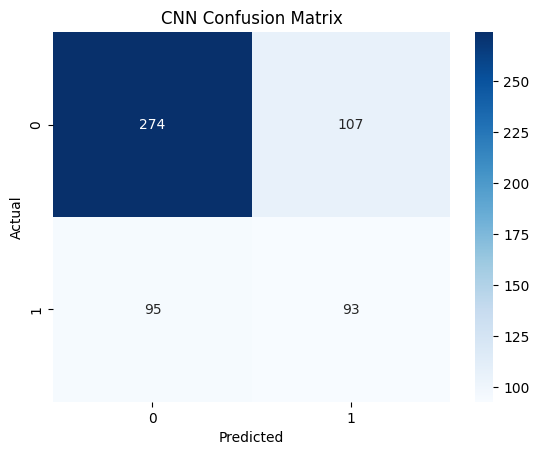

In [14]:
# Train Models (baseline)

model_ffn, hist_ffn = model_training_pipeline(model_type='ffn', epochs=40)

# Train LSTM
model_lstm, hist_lstm = model_training_pipeline(model_type='lstm', seq_length=10, epochs=30)

# Train CNN
model_cnn, hist_cnn = model_training_pipeline(model_type='cnn', seq_length=10, epochs=30)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Model Comparison Summary:
            Model  Accuracy       AUC  F1 Score
0  Feedforward NN  0.647668  0.610716  0.482234
2        CNN (1D)  0.644991  0.606920  0.479381
1      LSTM (RNN)  0.695958  0.591089  0.379928


<Figure size 800x500 with 0 Axes>

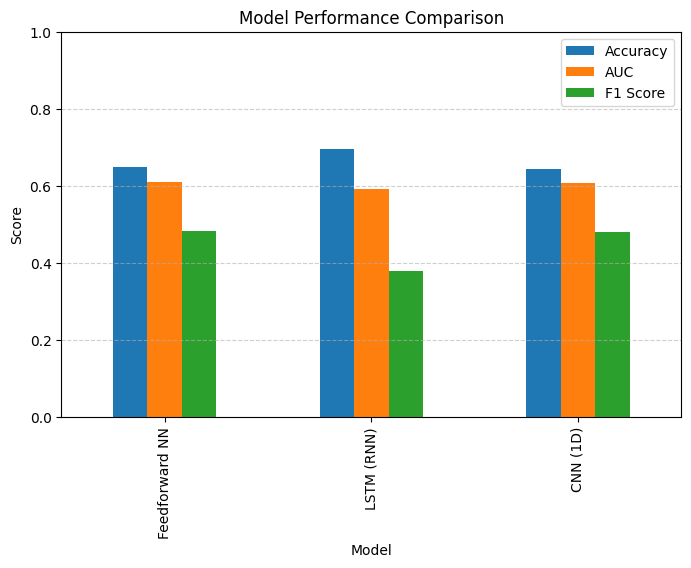

In [15]:
# Evaluate Model
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import pandas as pd

def evaluate_model(model, X_test, y_test, model_type, seq_length=10):
    """Evaluates a trained model and returns performance metrics."""
    if model_type in ['lstm', 'cnn']:
        # Build sequences for sequence-based models
        X_seq, y_seq = make_sequences(X_test, y_test, seq_length)
        preds = (model.predict(X_seq) > 0.5).astype(int).flatten()
        y_true = y_seq
    else:
        preds = (model.predict(X_test) > 0.5).astype(int).flatten()
        y_true = y_test

    acc = accuracy_score(y_true, preds)
    auc = roc_auc_score(y_true, preds)
    f1 = f1_score(y_true, preds)
    return acc, auc, f1

# --- Collect metrics for each model ---
metrics_summary = []

# Define the actual feature column names (excluding 'Target')
# This needs to be consistent with how X_train, X_val, X_test were prepared in model_training_pipeline
feature_names_for_prediction = [f for f in features if f != 'Target']

# Feedforward
X_test_ffn = test_df[feature_names_for_prediction].values
y_test_ffn = test_df['Target'].values
acc_ffn, auc_ffn, f1_ffn = evaluate_model(model_ffn, X_test_ffn, y_test_ffn, "ffn")
metrics_summary.append(["Feedforward NN", acc_ffn, auc_ffn, f1_ffn])

# LSTM
X_test_seq = test_df[feature_names_for_prediction].values
y_test_seq = test_df['Target'].values
acc_lstm, auc_lstm, f1_lstm = evaluate_model(model_lstm, X_test_seq, y_test_seq, "lstm")
metrics_summary.append(["LSTM (RNN)", acc_lstm, auc_lstm, f1_lstm])

# CNN
acc_cnn, auc_cnn, f1_cnn = evaluate_model(model_cnn, X_test_seq, y_test_seq, "cnn")
metrics_summary.append(["CNN (1D)", acc_cnn, auc_cnn, f1_cnn])

# --- Create summary dataframe ---
results_df = pd.DataFrame(metrics_summary, columns=["Model", "Accuracy", "AUC", "F1 Score"])
print("\nModel Comparison Summary:")
print(results_df.sort_values(by="AUC", ascending=False))

# --- Plot comparison ---
plt.figure(figsize=(8,5))
results_df.set_index("Model")[["Accuracy", "AUC", "F1 Score"]].plot(kind='bar', figsize=(8,5))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [16]:
# --- Select the best model based on Accuracy ---
import joblib

best_idx = results_df["Accuracy"].idxmax()
best_model_name = results_df.loc[best_idx, "Model"]
print(f"\nBest Model based on Accuracy: {best_model_name}")

# Map model name to object
model_mapping = {
    "Feedforward NN": model_ffn,
    "LSTM (RNN)": model_lstm,
    "CNN (1D)": model_cnn
}

best_model = model_mapping[best_model_name]

# --- Save the best model ---
save_dir = "best_model"
os.makedirs(save_dir, exist_ok=True)

# Save strictly in the new Keras format (works for FFN, LSTM, and CNN)
model_filename = "final_model.keras"
save_path = os.path.join(save_dir, model_filename)
best_model.save(save_path)

print(f"Model saved successfully in native Keras format at: {save_path}")



Best Model based on Accuracy: LSTM (RNN)
Model saved successfully in native Keras format at: best_model\final_model.keras


In [17]:
import joblib
import os

# Save the scaler object to the same folder as your model
save_dir = "best_model"
os.makedirs(save_dir, exist_ok=True)

scaler_path = os.path.join(save_dir, "scaler.pkl")
joblib.dump(scaler, scaler_path)

print(f"Scaler saved successfully at: {scaler_path}")

Scaler saved successfully at: best_model\scaler.pkl
